In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D,Cropping1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

%matplotlib inline
import pylab as plt

from keras.datasets import mnist

from utiles import *

In [6]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train.shape

(60000, 784)

In [15]:
def encoder_cnn_1d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   pool_size,
                   activity_regularizer):
    
    y = Conv1D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if pool_size and pool_size!=1:
        y = MaxPooling1D(pool_size=pool_size,
                         strides=None,
                         padding='same')(y)
    return y

def decoder_cnn_1d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   upsample_size,
                   activity_regularizer):
    
    y = Conv1D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if upsample_size and upsample_size!=1:
        y = UpSampling1D(size=upsample_size)(y)
    return y

def cond1d_arch_encoder(x_in,
                        latent_dim,
                        n_conv,
                        activation = 'relu',
                        filters = 4,
                        filter_factor = 2,
                        last_filters = None,
                        kernel_size = 5,
                        strides = 1,
                        pool_size = 2,
                        activity_regularizer=None):

    x = x_in

    for _ in range(n_conv-1):
        x = encoder_cnn_1d(x,
                          filters = filters,
                          kernel_size = kernel_size,
                          strides = strides,
                          activation = activation,
                          pool_size = pool_size,
                          activity_regularizer=activity_regularizer)
        filters = int(filters*filter_factor)
        
    if last_filters is None:
        last_filters = filters
        
    x = encoder_cnn_1d(x,
                       filters = last_filters,
                       kernel_size = kernel_size,
                       strides = strides,
                       activation = activation,
                       pool_size=0,
                       activity_regularizer=activity_regularizer)

    x_shape = x.get_shape().as_list()

    x = Flatten()(x)

    encoded = Dense(latent_dim,
              activation=activation)(x)
    
    return encoded,x_shape

def cond1d_arch_decoder(encoded,
                        decoded_dim,
                        n_conv,
                        x_shape,
                        activation = 'relu',
                        filters = 4,
                        filter_factor = 2,
                        last_filters = 1,
                        kernel_size = 5,
                        strides = 1,
                        upsample_size = 2,
                        activity_regularizer=None):

    x = Dense(x_shape[1]*x_shape[2],
              activation=activation)(encoded)

    x = Reshape(x_shape[1:])(x)

    for _ in range(n_conv-1):
        x = decoder_cnn_1d(x,
                           filters = filters,
                           kernel_size = kernel_size,
                           strides = strides,
                           activation = activation,
                           upsample_size = upsample_size,
                           activity_regularizer=activity_regularizer)
        filters = int(filters//filter_factor)
        
    decoded = decoder_cnn_1d(x,
                             filters = last_filters,
                             kernel_size = kernel_size,
                             strides = strides,
                             activation = activation,
                             upsample_size = 0,
                             activity_regularizer=activity_regularizer)

    delta_n = decoded.get_shape().as_list()[1] - decoded_dim

    d_crop = int(delta_n/2)
    if delta_n%2==0:
        decoded = Cropping1D((d_crop,d_crop))(decoded)
    else:
        decoded = Cropping1D((d_crop,d_crop+1))(decoded)
    
    return decoded
    pass

In [17]:
n_feature = 784
latent_dim = 10
n_conv = 5
activation='relu'
filters=4
kernel_size=5
strides=1
pool_size = 2
upsample_size=2


x_in = Input(shape=(n_feature, 1)) 

encoded,x_shape = cond1d_arch_encoder(x_in,
                                      latent_dim,
                                      n_conv,
                                      activation = activation,
                                      filters = filters,
                                      kernel_size = kernel_size,
                                      strides = strides,
                                      pool_size = pool_size)

decoded = cond1d_arch_decoder(encoded,
                              n_feature,
                              n_conv,
                              x_shape,
                              activation = activation,
                              filters = x_shape[-1],
                              kernel_size = kernel_size,
                              strides = strides,
                              upsample_size = upsample_size)

autoencoder = Model(x_in, decoded)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784, 1)]          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 784, 4)            24        
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 392, 4)            0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 392, 8)            168       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 196, 8)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 196, 16)           656       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 98, 16)            0   

In [20]:
class ConvolutionalAutoEncoder1D(AutoEncoderBase):
    def __init__(self,
                 input_dim,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 filter_factor = 2,
                 kernel_size = 5,
                 strides = 1,
                 pool_size = 2,
                 upsample_size = 2,
                 activation = 'relu',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.n_conv = n_conv
        self.filters = filters
        self.filter_factor = filter_factor
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim, 1)) 
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded,self.x_shape = cond1d_arch_encoder(x_in,
                                                   self.latent_dim,
                                                   self.n_conv,
                                                   activation = self.activation,
                                                   filters = self.filters,
                                                   filter_factor = self.filter_factor,
                                                   kernel_size = self.kernel_size,
                                                   strides = self.strides,
                                                   pool_size = self.pool_size,
                                                   activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):

        decoded = cond1d_arch_decoder(encoded,
                                      self.input_dim,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.x_shape[-1],
                                      filter_factor = self.filter_factor,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        return super().encoder(x)

In [26]:
cae = ConvolutionalAutoEncoder1D(784,2,n_conv = 2, filter_factor = 1.2)
cae.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 784, 1)]          0         
_________________________________________________________________
conv1d_84 (Conv1D)           (None, 784, 4)            24        
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 392, 4)            0         
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 392, 4)            84        
_________________________________________________________________
flatten_13 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 3138      
_________________________________________________________________
dense_26 (Dense)             (None, 1568)              470

In [27]:
cae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 20s 331us/sample - loss: 0.0903

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 20s 332us/sample - loss: 0.0698

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 20s 329us/sample - loss: 0.0671

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 20s 329us/sample - loss: 0.0665

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 21s 343us/sample - loss: 0.0662
Epoch 00005: early stopping


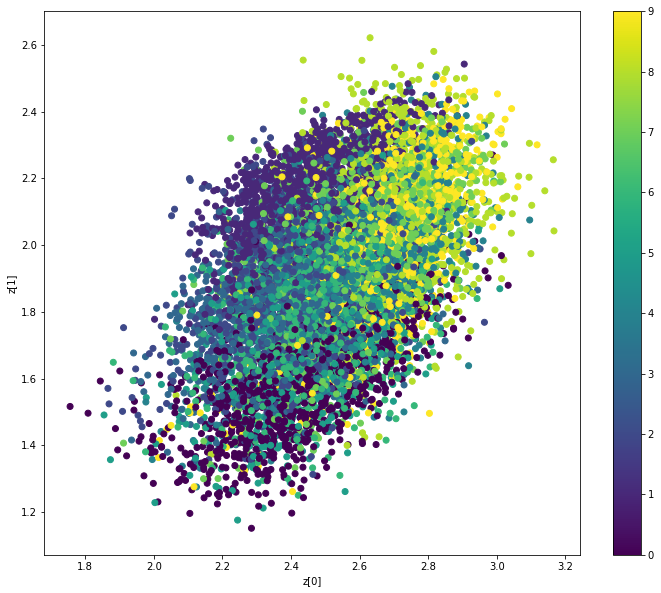

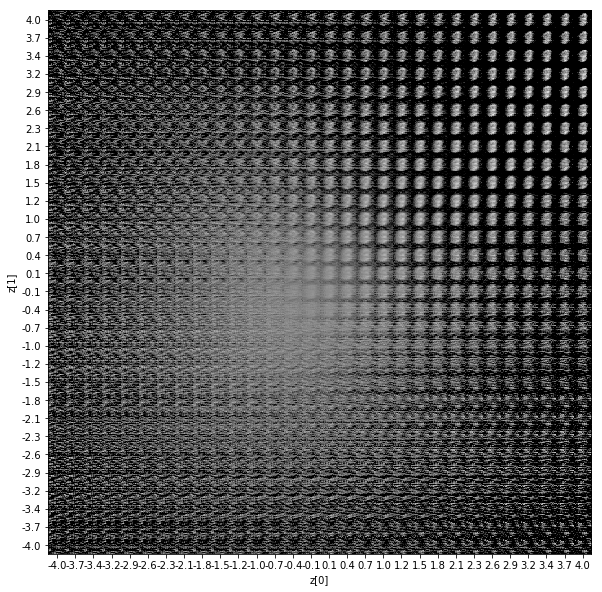

In [28]:
cae.illustration(data=(x_test,y_test))

In [30]:
class ConvolutionalVariationalAutoEncoder1D(AutoEncoderBase):
    def __init__(self,
                 input_dim,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 filter_factor = 2,
                 kernel_size = 5,
                 strides = 1,
                 pool_size = 2,
                 upsample_size = 2,
                 activation = 'relu',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size,
                         variational = True)
        
        self.n_conv = n_conv
        self.filters = filters
        self.filter_factor = filter_factor
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim, 1)) 
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        x,self.x_shape = cond1d_arch_encoder(x_in,
                                             2*self.latent_dim,
                                             self.n_conv,
                                             activation = self.activation,
                                             filters = self.filters,
                                             filter_factor = self.filter_factor,
                                             kernel_size = self.kernel_size,
                                             strides = self.strides,
                                             pool_size = self.pool_size,
                                             activity_regularizer = self.activity_regularizer)
        
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = cond1d_arch_decoder(encoded,
                                      self.input_dim,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.x_shape[-1],
                                      filter_factor = self.filter_factor,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        return super().encoder(x)

In [32]:
cvae = ConvolutionalVariationalAutoEncoder1D(784,2,n_conv = 3)
cvae.summary()

W1115 18:01:15.426472 139677953693504 training_utils.py:1348] Output cropping1d_11 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cropping1d_11.


Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 784, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_94 (Conv1D)              (None, 784, 4)       24          input_24[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_38 (MaxPooling1D) (None, 392, 4)       0           conv1d_94[0][0]                  
__________________________________________________________________________________________________
conv1d_95 (Conv1D)              (None, 392, 8)       168         max_pooling1d_38[0][0]           
___________________________________________________________________________________________

In [33]:
cvae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 38s 628us/sample - loss: 52.0991

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 35s 586us/sample - loss: 45.9093

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 35s 588us/sample - loss: 45.0989

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 36s 595us/sample - loss: 44.7788

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 35s 590us/sample - loss: 44.6145

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [==============================] - 36s 592us/sample - loss: 44.5596

Epoch 00007: 

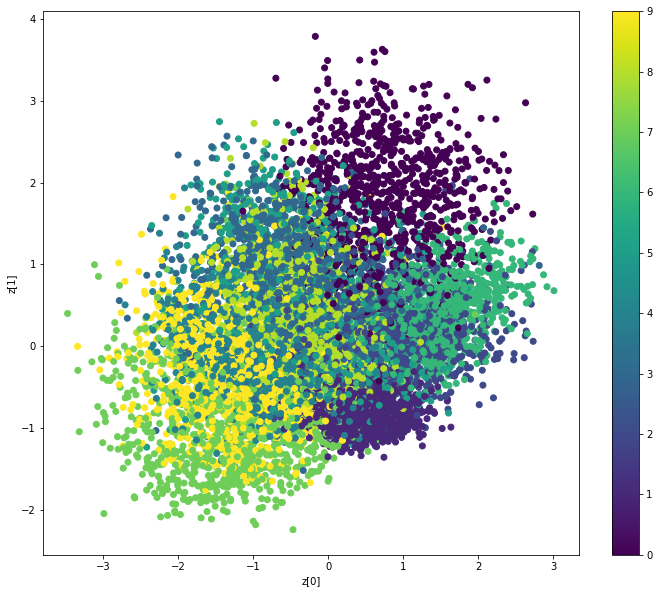

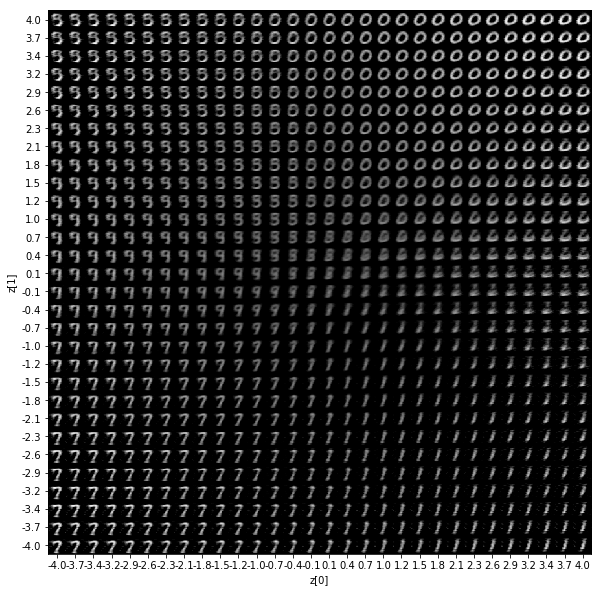

In [34]:
cvae.illustration(data=(x_test,y_test))